# STOCK PRICE FORECASTING USING LONG SHORT TERM MEMORY

From previous [discussion](https://github.com/yiqiao-yin/YinsPy/blob/master/scripts/python_MM_LSTM_StockPriceForecast.ipynb), I have demonstrated step by step how to split price data taken from a selected stock into training set and testing set and then how to construct a Long Short Term Memory architecture with 4 hidden layers to build a data-driven and predictive machine learning algorithm.

In this notebook, I will improve the algorithm by 
- allowing user to input his or her favorite stock
- allowing user to change number of hidden neurons per layer 
- allowing user to optimize architecture by allowing user to change *optimizer* and *loss* functions

Hence, I cover the following steps:
- **Data Processing and Cleanup**
- **Construct RNN**
- **Train RNN**
- **Predictions**
- **Performance Visualization**
- **Software Product / Product Management**

### Data Processing and Cleanup

In [74]:
from scipy import stats
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [75]:
# Define function
def getDatafromYF(ticker, start_date, end_date):
    stockData = yf.download(ticker, start_date, end_date)
    return stockData
# End function

In [76]:
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')
tickers = ['AAPL', 'SPY']

# Start with Dictionary (this is where data is saved)
stockData = {}
for i in tickers:
    stockData[i] = pd.DataFrame(getDatafromYF(str(i), start_date, end_date))
    close = stockData[i]['Adj Close']
    stockData[i]['Normalize Return'] = close / close.shift() - 1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [77]:
# Take a look
print(stockData[tickers[0]].head(2)) # this is desired stock
print(stockData[tickers[1]].head(2)) # this is benchmark (in this case, it is S&P 500 SPDR Index Fund: SPY)

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2013-01-02  79.117142  79.285713  77.375717  78.432854  68.850548  140129500   
2013-01-03  78.268570  78.524284  77.285713  77.442856  67.981491   88241300   

            Normalize Return  
Date                          
2013-01-02               NaN  
2013-01-03         -0.012622  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-01-02  145.110001  146.149994  144.729996  146.059998  127.252228   
2013-01-03  145.990005  146.369995  145.339996  145.729996  126.964752   

               Volume  Normalize Return  
Date                                     
2013-01-02  192059000               NaN  
2013-01-03  144761800         -0.002259  


In [78]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

In [79]:
stockData[tickers[0]].iloc[:, 4].head(3)

Date
2013-01-02    68.850548
2013-01-03    67.981491
2013-01-04    66.087891
Name: Adj Close, dtype: float64

In [80]:
data = stockData[tickers[0]].iloc[:, 4:5].values
sc = MinMaxScaler(feature_range = (0, 1))
scaled_dta = sc.fit_transform(data)
scaled_dta = pd.DataFrame(scaled_dta)

In [81]:
cutoff = 0.8

In [82]:
training_set = scaled_dta.iloc[0:round(scaled_dta.shape[0] * cutoff), :]
testing_set = scaled_dta.iloc[round(cutoff * scaled_dta.shape[0] + 1):scaled_dta.shape[0], :]

In [84]:
print(training_set.shape, testing_set.shape)

(1397, 1) (348, 1)


In [100]:
X_train = []
y_train = []

for i in range(100, training_set.shape[0]):
    X_train.append(np.array(training_set)[i-100:i, 0])
    y_train.append(np.array(training_set)[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1297, 100) (1297,)
(1297, 100, 1)


In [101]:
X_test = []
y_test = []

for i in range(100, testing_set.shape[0]):
    X_test.append(np.array(testing_set)[i-100:i, 0])
    y_test.append(np.array(testing_set)[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape, y_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(248, 100) (248,)
(248, 100, 1)


### Build RNN

In [102]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\Users\eagle\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [103]:
# Initialize RNN
regressor = Sequential()

In [104]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [105]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [106]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [107]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [108]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [109]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

### Train RNN

In [110]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [111]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 50, batch_size = 64)

Epoch 1/50
1297/1297 [==============================] - 5s 4ms/step - loss: 0.0203
Epoch 2/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0031
Epoch 3/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0022
Epoch 4/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0019
Epoch 5/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0018
Epoch 6/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0016
Epoch 7/50
1297/1297 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 8/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0016
Epoch 9/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0016
Epoch 10/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0017
Epoch 11/50
1297/1297 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 12/50
1297/1297 [==============================] - 3s 3ms/step - loss: 0.0014
E

### Predictions

In [124]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [134]:
real_stock_price = np.reshape(y_test, (y_test.shape[0], 1))
real_stock_price = sc.inverse_transform(real_stock_price)

### Performance Visualization

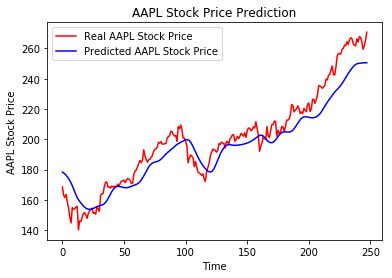

In [135]:
# Visualising the results
import matplotlib.pyplot as plt
plt.plot(real_stock_price, color = 'red', label = f'Real {tickers[0]} Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = f'Predicted {tickers[0]} Stock Price')
plt.title(f'{tickers[0]} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{tickers[0]} Stock Price')
plt.legend()
plt.show()

One can observe that the predicted path (blue line) is very much like the shape of the real stock price (red line).

In [136]:
import math
from sklearn.metrics import mean_squared_error

In [140]:
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(f'Root Mean Square Error is {round(rmse,2)} for test set.')
print(f'Interpretation: ---------------')
print(f'On the test set, the performance of this LSTM architecture guesses ')
print(f'{tickers[0]} stock price on average within the error of ${round(rmse,2)} dollars.')

Root Mean Square Error is 10.68 for test set.
Interpretation: ---------------
On the test set, the performance of this LSTM architecture guesses 
AAPL stock price on average within the error of $10.68 dollars.


### Software Product

In [149]:
# Define Function
def RNN4_Regressor(
    start_date = pd.to_datetime('2013-01-01'),
    end_date   = pd.to_datetime('2019-12-6'),
    tickers    = ['AAPL', 'SPY'], cutoff = 0.8,
    l1_units = 50, l2_units = 50, l3_units = 50, l4_units = 50,
    optimizer = 'adam', loss = 'mean_squared_error',
    epochs = 50, batch_size = 64,
    plotGraph = True,
    verbatim = True
):
    # Initiate Environment
    from scipy import stats
    import pandas as pd
    import numpy as np
    import yfinance as yf
    import matplotlib.pyplot as plt

    # Define function
    def getDatafromYF(ticker, start_date, end_date):
        stockData = yf.download(ticker, start_date, end_date)
        return stockData
    # End function

    # Start with Dictionary (this is where data is saved)
    stockData = {}
    for i in tickers:
        stockData[i] = pd.DataFrame(getDatafromYF(str(i), start_date, end_date))
        close = stockData[i]['Adj Close']
        stockData[i]['Normalize Return'] = close / close.shift() - 1

    # Take a look
    # print(stockData[tickers[0]].head(2)) # this is desired stock
    # print(stockData[tickers[1]].head(2)) # this is benchmark (in this case, it is S&P 500 SPDR Index Fund: SPY)

    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler

    stockData[tickers[0]].iloc[:, 4].head(3)

    data = stockData[tickers[0]].iloc[:, 4:5].values
    sc = MinMaxScaler(feature_range = (0, 1))
    scaled_dta = sc.fit_transform(data)
    scaled_dta = pd.DataFrame(scaled_dta)

    training_set = scaled_dta.iloc[0:round(scaled_dta.shape[0] * cutoff), :]
    testing_set = scaled_dta.iloc[round(cutoff * scaled_dta.shape[0] + 1):scaled_dta.shape[0], :]

    # print(training_set.shape, testing_set.shape)

    X_train = []
    y_train = []

    for i in range(100, training_set.shape[0]):
        X_train.append(np.array(training_set)[i-100:i, 0])
        y_train.append(np.array(training_set)[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    print(X_train.shape, y_train.shape)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print(X_train.shape)

    X_test = []
    y_test = []

    for i in range(100, testing_set.shape[0]):
        X_test.append(np.array(testing_set)[i-100:i, 0])
        y_test.append(np.array(testing_set)[i, 0])

    X_test, y_test = np.array(X_test), np.array(y_test)

    print(X_test.shape, y_test.shape)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print(X_test.shape)

    ### Build RNN

    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout

    # Initialize RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l4_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    regressor.summary()

    ### Train RNN

    # Compiling the RNN
    regressor.compile(optimizer = optimizer, loss = loss)

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

    ### Predictions

    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    real_stock_price = np.reshape(y_test, (y_test.shape[0], 1))
    real_stock_price = sc.inverse_transform(real_stock_price)

    ### Performance Visualization

    # Visualising the results
    import matplotlib.pyplot as plt
    if plotGraph:
        plt.plot(real_stock_price, color = 'red', label = f'Real {tickers[0]} Stock Price')
        plt.plot(predicted_stock_price, color = 'blue', label = f'Predicted {tickers[0]} Stock Price')
        plt.title(f'{tickers[0]} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel(f'{tickers[0]} Stock Price')
        plt.legend()
        plt.show()

    import math
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    if verbatim:
        print(f'Root Mean Square Error is {round(rmse,2)} for test set.')
        print(f'Interpretation: ---------------')
        print(f'On the test set, the performance of this LSTM architecture guesses ')
        print(f'{tickers[0]} stock price on average within the error of ${round(rmse,2)} dollars.')
    
    # Output
    return {
        'Information': [training_set.shape, testing_set.shape],
        'Data': [X_train, y_train, X_test, y_test],
        'Test Response': [predicted_stock_price, real_stock_price],
        'Test Error': rmse
    }
# End function

[*********************100%***********************]  1 of 1 completed
(1297, 100) (1297,)
(1297, 100, 1)
(248, 100) (248,)
(248, 100, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 50)      

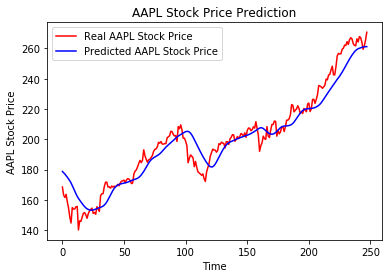

Root Mean Square Error is 8.36 for test set.
Interpretation: ---------------
On the test set, the performance of this LSTM architecture guesses 
AAPL stock price on average within the error of $8.36 dollars.


In [148]:
# Test Run
tmp = RNN3_Regressor(
    start_date = pd.to_datetime('2013-01-01'),
    end_date   = pd.to_datetime('2019-12-6'),
    tickers    = ['AAPL'], cutoff = 0.8,
    l1_units = 50, l2_units = 50, l3_units = 50, l4_units = 50,
    optimizer = 'adam', loss = 'mean_squared_error',
    plotGraph = True,
    verbatim = True )

### Load Functions from Package

The above function can be predefined in a *.py* script. I already did that and we can load the script and call the function.

In [155]:
%run "../scripts/YinsDL.py"

[*********************100%***********************]  1 of 1 completed
(1297, 100) (1297,)
(1297, 100, 1)
(248, 100) (248,)
(248, 100, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 50)      

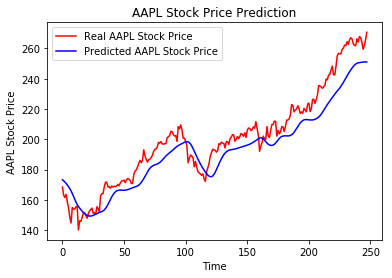

Root Mean Square Error is 11.39 for test set.
Interpretation: ---------------
On the test set, the performance of this LSTM architecture guesses 
AAPL stock price on average within the error of $11.39 dollars.


In [156]:
tmp = YinsDL.RNN4_Regressor(
        start_date = '2013-01-01',
        end_date   = '2019-12-6',
        tickers    = 'AAPL', cutoff = 0.8,
        l1_units = 50, l2_units = 50, l3_units = 50, l4_units = 50,
        optimizer = 'adam', loss = 'mean_squared_error',
        epochs = 50, batch_size = 64,
        plotGraph = True,
        verbatim = True )